## Importing

In [1]:
from __future__ import print_function
%load_ext autoreload
%autoreload 2
import time, os
from IPython import display

from pixell import enmap,utils as putils,reproject,enplot
from pixell.lensing import phi_to_kappa
from pixell.reproject import healpix2map,thumbnails
from pixell.curvedsky import alm2map,map2alm,almxfl
from pixell.pointsrcs import radial_bin

import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm, colors
from mpl_toolkits.mplot3d import Axes3D

import healpy as hp
from healpy.fitsfunc import read_alm,read_map

import symlens as s
from symlens import utils as sutils

# utils require orphics + pyfisher + enlib
from falafel import qe, utils as futils
import pytempura 

from orphics import maps, cosmology, io, stats, pixcov

# my own file
import websky_stack_and_visualize as josh_websky

plt.rcParams['figure.facecolor'] = 'white'

## Opening / preparing sims

In [2]:
PATH_TO_FALAFEL = "/home/joshua/research/falafel"
config = io.config_from_yaml(PATH_TO_FALAFEL + "/input/config.yml")
thloc = PATH_TO_FALAFEL + "/data/" + config['theory_root']
theory = cosmology.loadTheorySpectraFromCAMB(thloc,get_dimensionless=False)

# simulated maps file location
alm_filename = "../lensed_alm.fits"
alm_hp = read_alm(alm_filename)

# 0.5 (1.5 for now) arcmin resolution car geometry
shape, wcs = enmap.fullsky_geometry(res=np.deg2rad(1.5 / 60.))
# create empty map to overlay our map
omap = enmap.empty(shape, wcs, dtype=np.float32)
alm_px = alm2map(alm_hp, omap)

In [3]:
LMIN = 300
LMAX = 6000
MLMAX = 8000
ests = ['TT']

alms = map2alm(alm_px, lmax=LMAX)
beam_fwhm = 1.5 # arcmin
noise_t = 10. # noise stdev in uK-arcmin
# ucls['TT'] = C_ell_TT, tcls['TT'] = C_ell_TT + N_ell_TT 
ucls, tcls = futils.get_theory_dicts_white_noise(beam_fwhm, noise_t)

fTalm = futils.isotropic_filter([alms, alms*0., alms*0.],
                                 tcls, LMIN, LMAX, ignore_te=True)[0]

GLMAX = 2000
xfTalm = futils.isotropic_filter([alms, alms*0., alms*0.],
                                 tcls, LMIN, GLMAX, ignore_te=True)[0]

# lensing convergence file
kap_filename = "kap.fits"
RES = np.deg2rad(1.0 / 60.)
kap_px = josh_websky.px_to_car("../" + kap_filename, res=RES)
# filter to LMAX
kap_map = alm2map(map2alm(kap_px, lmax=LMAX), enmap.empty(shape, wcs, dtype=np.float32))

In [22]:
futils.isotropic_filter?
print(ucls['TT'].shape, tcls['TT'].shape)

(9001,) (9001,)


## Falafel lensing reconstruction

In [18]:
qe.qe_all?

In [4]:
px = qe.pixelization(shape=shape, wcs=wcs)

recon_alms = qe.qe_all(px, ucls, fTalm=fTalm, fEalm=fTalm*0., fBalm=fTalm*0.,
                       mlmax=MLMAX, estimators=ests)


## Tempura reconstruction normalization

In [5]:
# first index for the gradient
t_norms = pytempura.get_norms(ests, ucls, tcls, LMIN, LMAX, k_ellmax=LMAX, no_corr=False)

# create tempura normalized map
kappa_alms = phi_to_kappa(almxfl(recon_alms['TT'][0].astype(np.complex128),
                                 t_norms['TT'][0]))

kappa_map = alm2map(kappa_alms, enmap.empty(shape, wcs, dtype=np.float32))

In [19]:
pytempura.get_norms?

## Symlens reconstruction normalization

In [6]:
SYM_LMIN = 300
SYM_LMAX = 6000
SYM_GLMIN = 300
SYM_GLMAX = 2000

sym_shape, sym_wcs = enmap.geometry(res=1.5 * putils.arcmin,pos=[0,0],shape=(2000,2000), proj='plain') 

kmask = sutils.mask_kspace(sym_shape, sym_wcs, lmin=SYM_LMIN, lmax=SYM_LMAX)
g_kmask = sutils.mask_kspace(sym_shape, sym_wcs, lmin=SYM_GLMIN, lmax=SYM_LMAX)
g_cut_kmask = sutils.mask_kspace(sym_shape, sym_wcs, lmin=SYM_GLMIN, lmax=SYM_GLMAX)
# g_kmasker = lambda l: sutils.mask_kspace(sym_shape, sym_wcs, lmin=SYM_GLMIN, lmax=l)

# generate a feed_dict
feed_dict = {}
feed_dict_grad = {}
NOISE_T = noise_t
BEAM_FWHM = beam_fwhm # arcmin?
modlmap = enmap.modlmap(sym_shape, sym_wcs)

# from falafel/utils.py
# ells,gt,ge,gb,gte = np.loadtxt(f"{thloc}_camb_1.0.12_grads.dat",unpack=True,usecols=[0,1,2,3,4])
# nells = (NOISE_T*np.pi/180./60.)**2. / sutils.gauss_beam(BEAM_FWHM,modlmap)**2.
ells = np.arange(len(ucls['TT']))
#feed_dict_grad['uC_T_T'] = sutils.interp(ells, gt)(modlmap)
#feed_dict_grad['tC_T_T'] = feed_dict_grad['uC_T_T'] + nells
feed_dict['uC_T_T'] = sutils.interp(ells, ucls['TT'])(modlmap)
feed_dict['tC_T_T'] = sutils.interp(ells, tcls['TT'])(modlmap)

# generate normalization
s_norms = s.A_l(sym_shape,sym_wcs,feed_dict,"hdv","TT",xmask=g_kmask,ymask=kmask)
cut_s_norms = s.A_l(sym_shape,sym_wcs,feed_dict,"hdv","TT",xmask=g_cut_kmask,ymask=kmask)

## Symlens wrapper

In [7]:
def get_s_norms(ests, ucls, tcls, lmin, lmax, shape, wcs,
                GLMIN = None, GLMAX = None, noise_t = NOISE_T,
                beam_fwhm = BEAM_FWHM, grad_cut=False):
    feed_dict = {}
    modlmap = enmap.modlmap(shape, wcs)
    kmask = sutils.mask_kspace(shape, wcs, lmin=lmin, lmax=lmax)
    g_kmask = sutils.mask_kspace(shape, wcs,
                                 lmin=(LMIN if GLMIN == None else GLMIN),
                                 lmax=(LMAX if GLMAX == None else GLMAX))
    
    results = {}
    for est in ests:
        ells = np.arange(len(ucls[est]))
        feed_dict['uC_T_T'] = sutils.interp(ells, ucls[est])(modlmap)
        feed_dict['tC_T_T'] = sutils.interp(ells, tcls[est])(modlmap)
        
        norms = s.A_l(shape, wcs, feed_dict, "hdv", est, xmask=g_kmask, ymask=kmask)
        results[est] = norms
    
    return results

def s_norms_formatter(s_norms, kells, shape, wcs, lmin, lmax, lwidth):
    # binning 
    modlmap = enmap.modlmap(shape, wcs)
    Lrange = np.arange(lmin, lmax, lwidth)
    binner = stats.bin2D(modlmap, Lrange)

    l_factor = modlmap * (modlmap + 1) / 4.
    centers, binned_norms = binner.bin(s_norms * l_factor)
    
    # generate norms object by interpolating
    Al = maps.interp(centers, binned_norms, kind='cubic')(kells)
    return Al

## Radial binning functions

In [8]:
# works for rectangles too!
# returns map where values represent arcmin distance from the center of the map
def distance_map(imap, res):
    [xdim, ydim] = imap.shape
    xvec, yvec = np.ones(xdim), np.ones(ydim)
    # create an array of size N, centered at 0 and incremented by pixel count
    xinds, yinds = (np.arange(xdim) + 0.5 - xdim/2.), (np.arange(ydim) + 0.5 - ydim/2.)
    # compute the outer product matrix: X[i, j] = onesvec[i] * inds[j] for i,j 
    # in range(N), which is just N rows copies of inds - for the x dimension
    x = np.outer(xvec, yinds)
    y = np.outer(xinds, yvec)
    r = np.sqrt(x**2 + y**2)
    
    return r * res

# gonna write my own function
def radial_sum_own(imap, res, bins, weights=None):
    dmap = distance_map(imap, res)
    if weights is not None: imap = imap * weights
    result = []
    
    for in_bin, out_bin in zip(bins, bins[1:]):
        # indices
        (xcoords, ycoords) = np.where(np.logical_and(dmap >= in_bin, dmap < out_bin))
        coords = [(xcoords[i], ycoords[i]) for i in range(len(xcoords))]
        # sum of values within the annulus of distance
        result.append(sum([imap[x,y] for (x,y) in coords]))
        
    return result

def radial_lsum_own(imap, shape, wcs, bins, weights=None):
    dmap = enmap.modlmap(shape, wcs)
    if weights is not None: imap = imap * weights
    result = []
    
    for in_bin, out_bin in zip(bins, bins[1:]):
        # indices
        (xcoords, ycoords) = np.where(np.logical_and(dmap >= in_bin, dmap < out_bin))
        coords = [(xcoords[i], ycoords[i]) for i in range(len(xcoords))]
        # sum of values within the annulus of distance
        result.append(sum([imap[x,y] for (x,y) in coords]))
        
    return result

def radial_avg_own(imap, res, bins, weights=None):
    numerator = radial_sum_own(imap, res, bins, weights)
    map_ones = 1. + enmap.empty(imap.shape, imap.wcs, dtype=np.float32)
    denominator = radial_sum_own(map_ones, res, bins, None)
    assert len(numerator) == len(denominator), "unequal sizes of numerator + denominator for averaging"
    
    return [numerator[i] / denominator[i] for i in range(len(numerator))]

def radial_avg2_own(imap, res, bins, weights=None):
    dmap = distance_map(imap, res)
    if weights is not None: imap = imap * weights
    result = []
    
    for in_bin, out_bin in zip(bins, bins[1:]):
        # indices
        (xcoords, ycoords) = np.where(np.logical_and(dmap >= in_bin, dmap < out_bin))
        coords = [(xcoords[i], ycoords[i]) for i in range(len(xcoords))]
        # sum of values within the annulus of distance
        result.append(sum([imap[x,y] for (x,y) in coords]) / len(coords))
        
    return result

# aggregate values in L into a new list of Nnew indices
def listcollector(L, Nnew):
    result = []
    agg_size = len(L) // Nnew
    for i in range(Nnew):
        result.append(sum(L[i*agg_size:(i+1)*agg_size]))
    return result

## Verifying binning results

In [11]:
# indices
kells = np.arange(t_norms['TT'][0].shape[0])
# tempura with l^4 factors
Al_temp = t_norms['TT'][0] * (kells * (kells + 1) / 2.)**2

# binning setup
Lwidth = 50
Lrange = np.arange(LMIN,LMAX,Lwidth)
binner = stats.bin2D(modlmap, Lrange)

# bin symlens
l_factor = modlmap * (modlmap + 1) / 4.
centers, binned_s_norms = binner.bin(s_norms * l_factor)

# interpolate symlens norms for tempura format
Al_sym = maps.interp(centers, binned_s_norms, kind='cubic')(kells)

In [12]:
# does the same thing
s_norms = get_s_norms(ests, ucls, tcls, LMIN, LMAX, sym_shape, sym_wcs)
Al_sym = s_norms_formatter(s_norms['TT'], kells, sym_shape, sym_wcs, LMIN, LMAX, Lwidth)

In [13]:
# gradient cut symlens
cut_s_norms = get_s_norms(ests, ucls, tcls, LMIN, LMAX, sym_shape, sym_wcs,
                          GLMIN=SYM_GLMIN, GLMAX=SYM_GLMAX, grad_cut=True)
Al_cut_sym = s_norms_formatter(cut_s_norms['TT'], kells, sym_shape, sym_wcs, LMIN, LMAX, Lwidth)

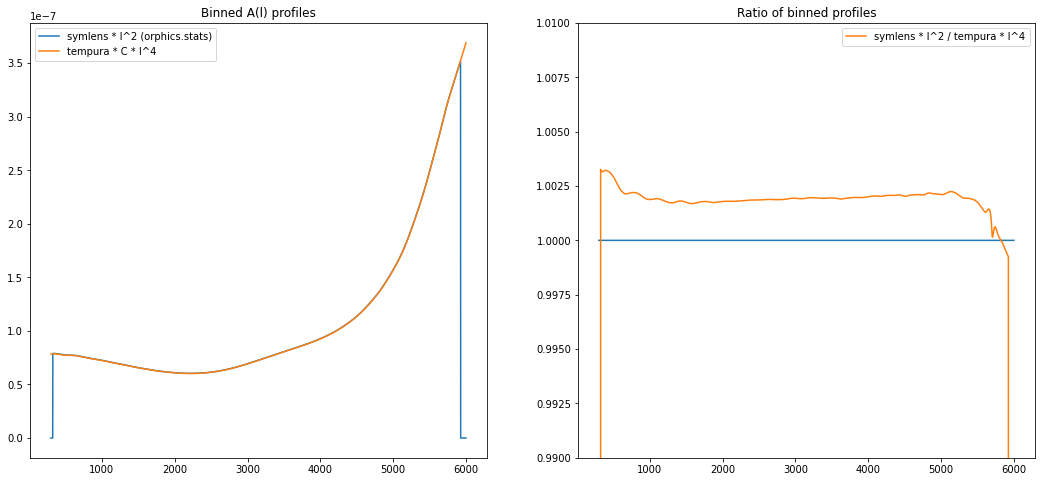

In [15]:
# plot symlens * l^2 vs tempura * l^4
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(18,8))

axes[0].set_title("Binned A(l) profiles")
axes[0].plot(kells[LMIN:LMAX+1], Al_sym[LMIN:LMAX+1], label="symlens * l^2 (orphics.stats)")
axes[0].plot(kells[LMIN:LMAX+1], Al_temp[LMIN:LMAX+1], label="tempura * C * l^4")
axes[0].legend()

axes[1].set_title("Ratio of binned profiles")
axes[1].set_ylim(0.99,1.01)
axes[1].plot(kells[LMIN:LMAX+1], 1. + np.zeros(LMAX-LMIN+1))
axes[1].plot(kells[LMIN:LMAX+1], Al_sym[LMIN:LMAX+1] / Al_temp[LMIN:LMAX+1], label="symlens * l^2 / tempura * l^4")
axes[1].legend()

plt.savefig("binned-als-new-plus-deltas.png")
plt.show()

NameError: name 'Al_sym2' is not defined

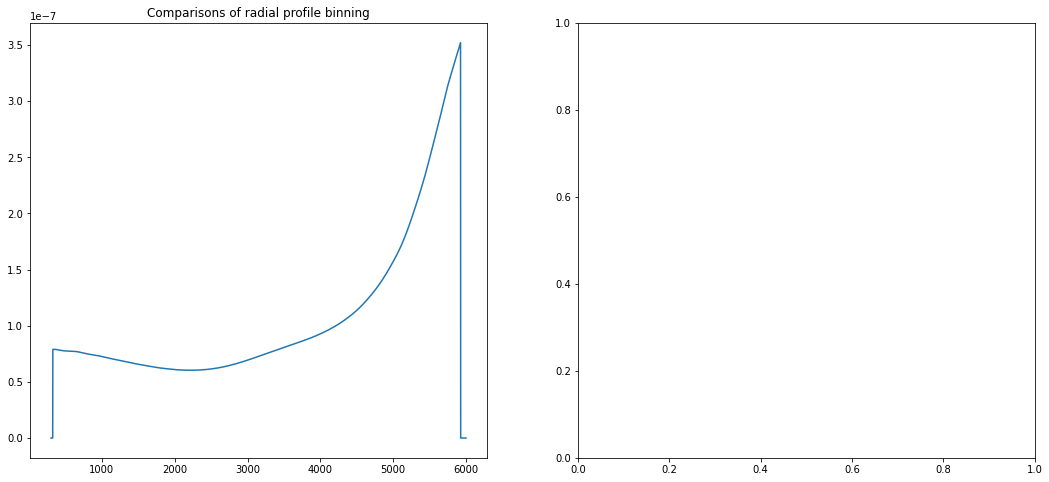

In [16]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(18,8))
axes[0].set_title("Comparisons of radial profile binning")
axes[0].plot(kells[LMIN:LMAX+1], Al_sym[LMIN:LMAX+1], label="symlens * l^2 (l^2 factor post-binning)")
axes[0].plot(kells[LMIN:LMAX+1], Al_sym2[LMIN:LMAX+1], label="symlens * l^2 (l^2 factor pre-binning)")
axes[0].legend()

axes[1].set_title("Ratio of radial profile binning")
axes[1].plot(kells[LMIN:LMAX+1], Al_sym[LMIN:LMAX+1] / Al_sym2[LMIN:LMAX+1],
            label="l^2 factor post-bin / pre-bin")
axes[1].legend()
plt.savefig("comparing-radial-profile-binning.png")

## Plotting stacked kappa maps

In [14]:
# generating maps by performing A_l * phi and converting to kappa
# alms are the output values from falafel QE
def mapper(norms, alms, lmin=LMIN, lmax=LMAX, shape=shape, wcs=wcs):
    phi_product = almxfl(alms['TT'][0].astype(np.complex128),
                         np.array([0. if (i < LMIN or i > LMAX)
                                   else norms[i] for i in range(len(norms))]))
    return alm2map(phi_to_kappa(phi_product), enmap.empty(shape, wcs, dtype=np.float32))


symlens_map = mapper(Al_sym / (kells * (kells + 1) / 2.)**2, recon_alms)
symlens_cut_map = mapper(Al_cut_sym / (kells * (kells + 1) / 2.)**2, recon_alms)
tempura_map = mapper(Al_temp / (kells * (kells + 1) / 2.)**2, recon_alms)

/tmp/ipykernel_2169/1536973242.py:10: RuntimeWarning: invalid value encountered in true_divide
  symlens_map = mapper(Al_sym / (kells * (kells + 1) / 2.)**2, recon_alms)
/tmp/ipykernel_2169/1536973242.py:11: RuntimeWarning: invalid value encountered in true_divide
  symlens_cut_map = mapper(Al_cut_sym / (kells * (kells + 1) / 2.)**2, recon_alms)
/tmp/ipykernel_2169/1536973242.py:12: RuntimeWarning: invalid value encountered in true_divide
  tempura_map = mapper(Al_temp / (kells * (kells + 1) / 2.)**2, recon_alms)


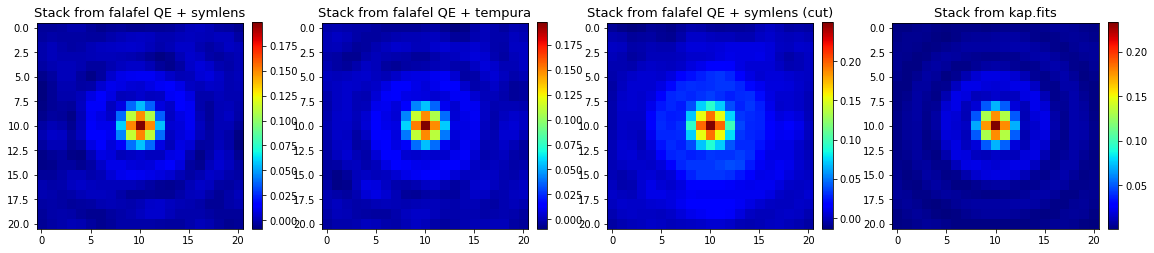

In [15]:
full_ra, full_dec = josh_websky.read_coords_from_file("1e6_massive_halos.txt")
NCOORDS = 10000
RES = np.deg2rad(1.0 / 60.)

# stack QE recon'd maps 
stack_map, avg_s_map = josh_websky.stack_average_random(symlens_map, full_ra, full_dec, Ncoords=NCOORDS,
                                                      radius=10*RES, res=RES)

stack_map, avg_s_cut_map = josh_websky.stack_average_random(symlens_cut_map, full_ra, full_dec, Ncoords=NCOORDS,
                                                      radius=10*RES, res=RES)

stack_s_map, avg_t_map = josh_websky.stack_average_random(tempura_map, full_ra, full_dec, Ncoords=NCOORDS,
                                                          radius=10*RES, res=RES)

# stack kap.fits convergence map
stack_kap, avg_kap = josh_websky.stack_average_random(kap_map, full_ra, full_dec, Ncoords=NCOORDS,
                                                      radius=10*RES, res=RES)           

fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(16,48))

im1 = axes[0].imshow(avg_s_map, cmap='jet')
axes[0].set_title("Stack from falafel QE + symlens", fontsize=13)
im2 = axes[1].imshow(avg_t_map, cmap='jet')
axes[1].set_title("Stack from falafel QE + tempura", fontsize=13)
im3 = axes[2].imshow(avg_s_cut_map, cmap='jet')
axes[2].set_title("Stack from falafel QE + symlens (cut)", fontsize=13)
im4 = axes[3].imshow(avg_kap, cmap='jet')
axes[3].set_title("Stack from kap.fits", fontsize=13)

fig.subplots_adjust(right=0.85)
fig.colorbar(im1, ax = axes[0], fraction=0.046, pad=0.04)
fig.colorbar(im2, ax = axes[1], fraction=0.046, pad=0.04)
fig.colorbar(im3, ax = axes[2], fraction=0.046, pad=0.04)
fig.colorbar(im4, ax = axes[3], fraction=0.046, pad=0.04)

plt.tight_layout()
plt.savefig("full-data-stacks.png")
plt.show()

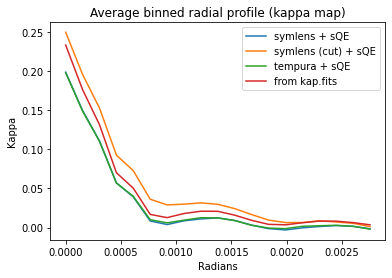

In [16]:
res = np.deg2rad(1.0 / 60.)
N = 20
res_range = np.linspace(0, 10 * res, N)
binned_kap = radial_avg2_own(avg_kap, res, res_range)
binned_tkap = radial_avg2_own(avg_t_map, res, res_range)
binned_skap = radial_avg2_own(avg_s_map, res, res_range)
binned_skap2 = radial_avg2_own(avg_s_cut_map, res, res_range)

plt.title("Average binned radial profile (kappa map)")
plt.xlabel("Radians")
plt.ylabel("Kappa")
plt.plot(res_range[:-1], binned_skap, label="symlens + sQE")
plt.plot(res_range[:-1], binned_skap2, label="symlens (cut) + sQE")
plt.plot(res_range[:-1], binned_tkap, label="tempura + sQE")
plt.plot(res_range[:-1], binned_kap, label="from kap.fits")
plt.legend()
plt.savefig("kappa-binned-radial-profiles.png")

## Gradient cut (falafel recon)

In [17]:
xfTalm = futils.isotropic_filter([alms, alms*0., alms*0.],
                                 tcls, SYM_GLMIN, SYM_GLMAX, ignore_te=True)[0]

recon_cut_alms = qe.qe_all(px, ucls, fTalm=fTalm, fEalm=fTalm*0., fBalm=fTalm*0.,
                           xfTalm=xfTalm, xfEalm=xfTalm*0., xfBalm=xfTalm*0.,
                           mlmax=MLMAX, estimators=ests)

grad_cut_map = mapper(Al_cut_sym / (kells * (kells + 1) / 2.)**2, recon_cut_alms)

/tmp/ipykernel_2169/2170055548.py:8: RuntimeWarning: invalid value encountered in true_divide
  grad_cut_map = mapper(Al_cut_sym / (kells * (kells + 1) / 2.)**2, recon_cut_alms)


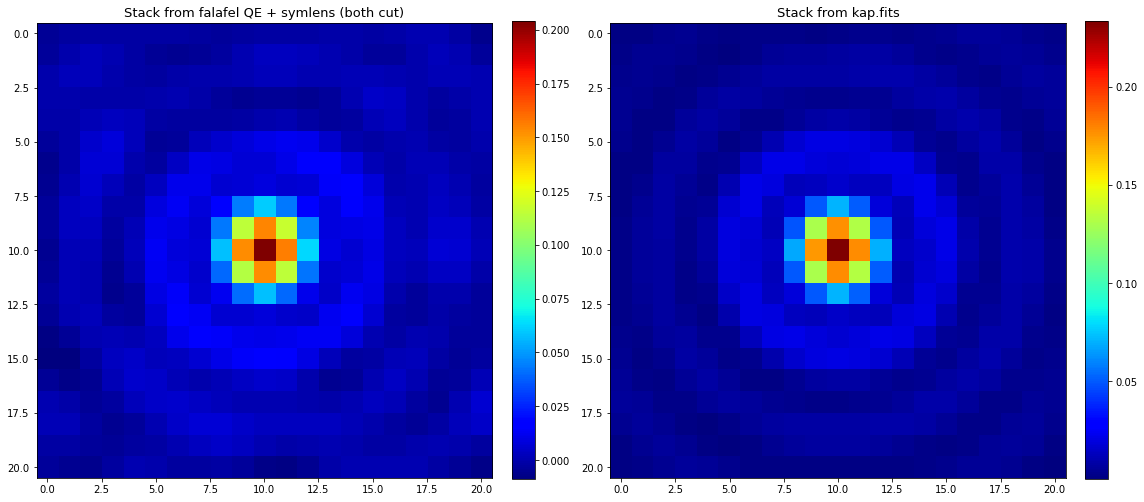

In [18]:
stack_map, avg_grad_cut_map = josh_websky.stack_average_random(grad_cut_map, full_ra, full_dec, Ncoords=NCOORDS,
                                                               radius=10*RES, res=RES)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16,24))
im1 = axes[0].imshow(avg_grad_cut_map, cmap='jet')
axes[0].set_title("Stack from falafel QE + symlens (both cut)", fontsize=13)
im2 = axes[1].imshow(avg_kap, cmap='jet')
axes[1].set_title("Stack from kap.fits", fontsize=13)

fig.subplots_adjust(right=0.85)
fig.colorbar(im1, ax = axes[0], fraction=0.046, pad=0.04)
fig.colorbar(im2, ax = axes[1], fraction=0.046, pad=0.04)

plt.tight_layout()
plt.savefig("gradient-cut.png")
plt.show()

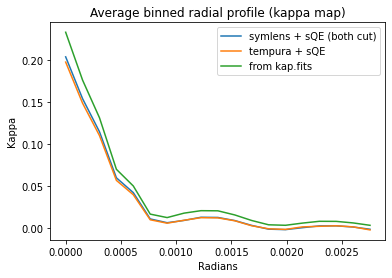

In [19]:
res = np.deg2rad(1.0 / 60.)
N = 20
res_range = np.linspace(0, 10 * res, N)
binned_kap = radial_avg2_own(avg_kap, res, res_range)
binned_tkap = radial_avg2_own(avg_t_map, res, res_range)
binned_skap3 = radial_avg2_own(avg_grad_cut_map, res, res_range)

plt.title("Average binned radial profile (kappa map)")
plt.xlabel("Radians")
plt.ylabel("Kappa")
plt.plot(res_range[:-1], binned_skap3, label="symlens + sQE (both cut)")
plt.plot(res_range[:-1], binned_tkap, label="tempura + sQE")
plt.plot(res_range[:-1], binned_kap, label="from kap.fits")
plt.legend()
plt.savefig("kappa-binned-radial-profiles-2.png")

## Mean field calculations

In [20]:
# http://corysimon.github.io/articles/uniformdistn-on-sphere/

## Incorrectly generate a uniform distribution of ra,dec around spherical projection
def wrong_ra_dec(N):
    return np.random.uniform(0, 2*np.pi, N), np.random.uniform(-np.pi/2, np.pi/2, N)

## Generate a uniform distribution of ra,dec around a spherical projection
def random_ra_dec(N, zero=1e-4):
    xyz = []
    while len(xyz) < N:
        [x,y,z] = np.random.normal(size=3)
        # for rounding errors
        if (x**2 + y**2 + z**2)**0.5 > zero: xyz.append([x,y,z])
    colat, ra = hp.vec2ang(np.array(xyz))
    return ra, np.pi/2 - colat


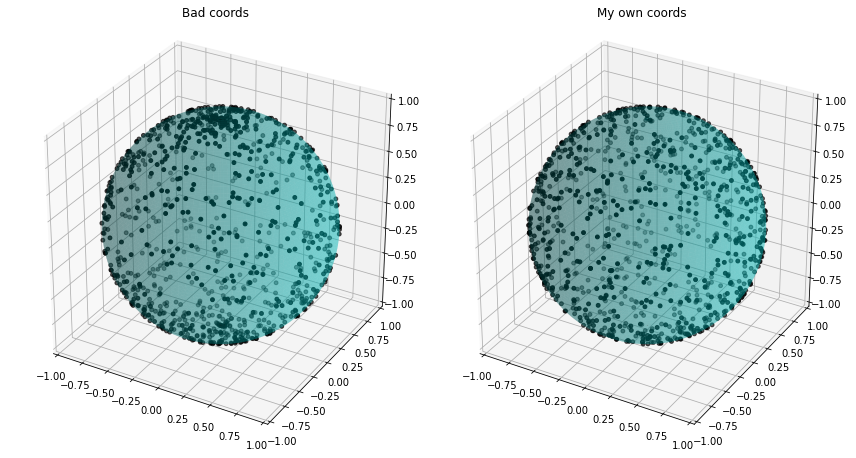

In [21]:
# checking via visuals if my ra / dec algorithm is working

bad_phi, bad_theta = wrong_ra_dec(1000)
good_phi, good_theta = random_ra_dec(1000)
 # convert dec back to colatitude (theta)
bad_theta = np.pi/2 - bad_theta
good_theta = np.pi/2 - good_theta

bad_x = np.sin(bad_theta) * np.cos(bad_phi)
bad_y = np.sin(bad_theta) * np.sin(bad_phi)
bad_z = np.cos(bad_theta)

good_x = np.sin(good_theta) * np.cos(good_phi)
good_y = np.sin(good_theta) * np.sin(good_phi)
good_z = np.cos(good_theta)

# create a sphere for the scatterplot framework
r = 1
thetas, phis = np.mgrid[0.0:np.pi:100j, 0.0:2.0*np.pi:100j]
xs = np.sin(thetas)*np.cos(phis)
ys = np.sin(thetas)*np.sin(phis)
zs = np.cos(thetas)

# plot
fig = plt.figure(figsize=(12,22))
ax1 = fig.add_subplot(121, projection='3d')
ax1.set_title("Bad coords")
ax2 = fig.add_subplot(122, projection='3d')
ax2.set_title("My own coords")

ax1.plot_surface(
    xs, ys, zs,  rstride=1, cstride=1, color='c', alpha=0.3, linewidth=0)
ax2.plot_surface(
    xs, ys, zs,  rstride=1, cstride=1, color='c', alpha=0.3, linewidth=0)

ax1.scatter(bad_x, bad_y, bad_z, color="k",s=15)
ax1.set_box_aspect((1,1,1))

ax1.set_xlim([-1,1])
ax1.set_ylim([-1,1])
ax1.set_zlim([-1,1])

ax2.scatter(good_x, good_y, good_z, color="k",s=15)
ax2.set_box_aspect((1,1,1))

ax2.set_xlim([-1,1])
ax2.set_ylim([-1,1])
ax2.set_zlim([-1,1])
plt.tight_layout()


In [5]:
## gonna save this to a file because this is a LOT of coordinates
MF_SAMPLES = 1e6

mean_ra, mean_dec = random_ra_dec(MF_SAMPLES)
np.savetxt("1e6-ra-decs.txt", np.column_stack((mean_ra, mean_dec)))

In [9]:
# stack, plot, and profile
t1 = time.time()
stack_mean_map, avg_mean_map = josh_websky.stack_average_random(kap_map, mean_ra, mean_dec,
                                                                Ncoords=int(MF_SAMPLES),
                                                                radius=10*RES, res=RES)   
t2 = time.time()
print("Time elapsed: %0.5f seconds" % (t2-t1))

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16,24))
im1 = axes[0].imshow(avg_mean_map, cmap='jet')
axes[0].set_title("Mean field stack from kap.fits", fontsize=13)
im2 = axes[1].imshow(avg_kap, cmap='jet')
axes[1].set_title("Stack from kap.fits", fontsize=13)

fig.subplots_adjust(right=0.85)
fig.colorbar(im1, ax = axes[0], fraction=0.046, pad=0.04)
fig.colorbar(im2, ax = axes[1], fraction=0.046, pad=0.04)

plt.tight_layout()
plt.savefig("mean-field-avg.png")
plt.show()

ValueError: unsupported format character ' ' (0x20) at index 18

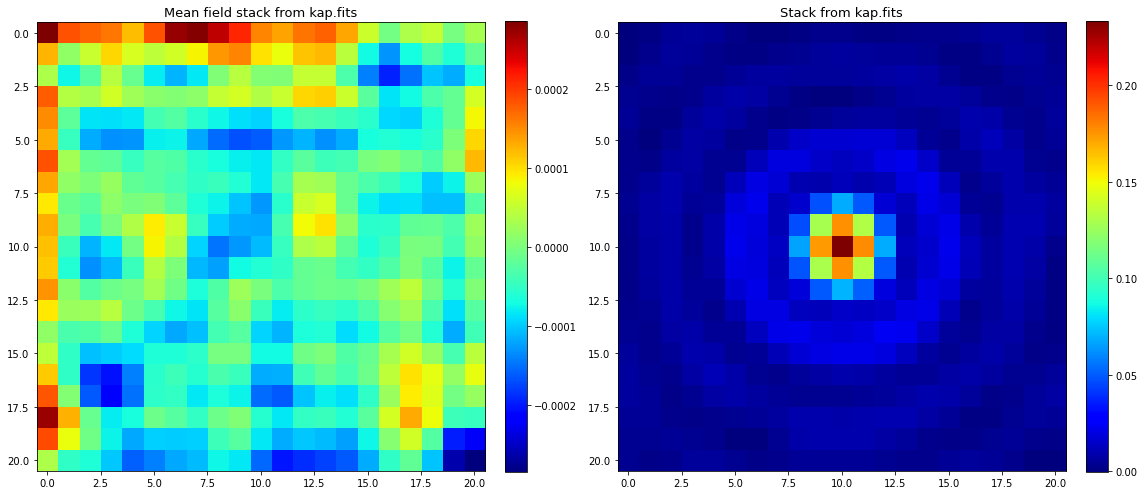

In [12]:
full_ra, full_dec = josh_websky.read_coords_from_file("1e6_massive_halos.txt")
RES = np.deg2rad(1.0 / 60.)

# stack kap.fits convergence map
stack_kap, avg_kap = josh_websky.stack_average_random(kap_map, full_ra, full_dec, Ncoords=NCOORDS,
                                                      radius=10*RES, res=RES)  

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16,24))
im1 = axes[0].imshow(avg_mean_map, cmap='jet')
axes[0].set_title("Mean field stack from kap.fits", fontsize=13)
im2 = axes[1].imshow(avg_kap, cmap='jet')
axes[1].set_title("Stack from kap.fits", fontsize=13)

fig.subplots_adjust(right=0.85)
fig.colorbar(im1, ax = axes[0], fraction=0.046, pad=0.04)
fig.colorbar(im2, ax = axes[1], fraction=0.046, pad=0.04)

plt.tight_layout()
plt.savefig("mean-field-avg.png")
plt.show()

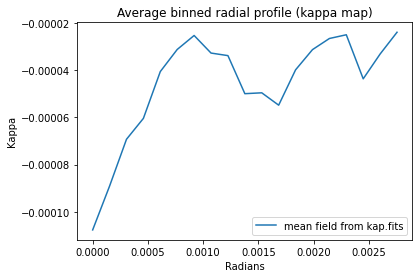

In [15]:
res = np.deg2rad(1.0 / 60.)
N = 20
res_range = np.linspace(0, 10 * res, N)
#binned_kap = radial_avg2_own(avg_kap, res, res_range)
binned_mkap = radial_avg2_own(avg_mean_map, res, res_range)

plt.title("Average binned radial profile (kappa map)")
plt.xlabel("Radians")
plt.ylabel("Kappa")
plt.plot(res_range[:-1], binned_mkap, label="mean field from kap.fits")
#plt.plot(res_range[:-1], binned_kap, label="from kap.fits")
plt.legend()
plt.savefig("mean-field-radial-profiles.png")

In [16]:
t2-t1

7030.442489862442